In [5]:
from OCC.Core.Quantity import Quantity_Color, Quantity_TOC_RGB
from pygem.cad.cad_deformation import CADDeformation
from OCC.Core.gp import gp_Pnt, gp_Dir, gp_Vec, gp_Trsf, gp_Ax2, gp_Ax1, gp_GTrsf
from OCC.Core.BRepPrimAPI import BRepPrimAPI_MakePrism
from OCC.Core.BRepBuilderAPI import BRepBuilderAPI_Transform, BRepBuilderAPI_MakeFace, BRepBuilderAPI_MakeWire, BRepBuilderAPI_MakeEdge, BRepBuilderAPI_NurbsConvert, BRepBuilderAPI_MakeShell, BRepBuilderAPI_Sewing
from OCC.Core.BRepAlgoAPI import BRepAlgoAPI_Section, BRepAlgoAPI_Fuse, BRepAlgoAPI_Cut
from OCC.Core.BOPAlgo import BOPAlgo_Splitter
from OCC.Core.Geom import Geom_Plane
from OCC.Core.Bnd import Bnd_Box
from OCC.Core.TopTools import TopTools_ListOfShape
from OCC.Core.TopExp import TopExp_Explorer
from OCC.Core.TopAbs import TopAbs_EDGE, TopAbs_VERTEX, TopAbs_FACE
from OCC.Core.BRep import BRep_Tool_Pnt, BRep_Tool_Surface, BRep_Tool, BRep_Tool_Curve

from OCC.Display.SimpleGui import init_display
from OCC.Core.TopoDS import TopoDS_Edge, topods_Edge, topods_Face
from OCC.Core.ShapeCustom import ShapeCustom_ConvertToBSpline
from OCC.Core.IGESControl import IGESControl_Reader
from OCC.Core.BRepBndLib import brepbndlib_Add
from OCC.Core.GeomConvert import GeomConvert_CompCurveToBSplineCurve, geomconvert_CurveToBSplineCurve, geomconvert_SurfaceToBSplineSurface
from OCC.Core.GeomAPI import GeomAPI_ProjectPointOnCurve, GeomAPI_ProjectPointOnSurf
from OCC.Core.BRepAdaptor import BRepAdaptor_Curve
from OCC.Core.GCPnts import GCPnts_UniformAbscissa
from OCC.Core.BRepGProp import BRepGProp_Face, BRepGProp_MeshProps, brepgprop_SurfaceProperties
from OCC.Core.GProp import GProp_GProps
import matplotlib.pyplot as plt
import numpy as np
import scipy as sci
import occhullmanipulation as occhm
from OCC.Core.Tesselator import ShapeTesselator
import openmesh as om
from OCC.Core.gp import gp_Vec, gp_Trsf, gp_Ax3
from OCC.Core.BRepBuilderAPI import BRepBuilderAPI_Transform

F = False
T = True
CAD = CADDeformation()
# file_path_sur = "C:\\PycharmProjects\\MasterThesis\\hullmod\\data\\test_1_hull_exported.igs"
file_path_sur = "C:\\PycharmProjects\\MasterThesis\\d3v-gsd-occ\\examples\\ROPAX_100M.igs"
reader_sur = IGESControl_Reader()
# Reading the file, make sure you update path. Note in Windows slash needs to be used
reader_sur.ReadFile(file_path_sur)
# Prepareing the surface
reader_sur.TransferRoots()
shape_sur = reader_sur.Shape()
bbox = Bnd_Box()
bbox.SetGap(1e-5)
brepbndlib_Add(shape_sur, bbox, False)
xmin, ymin, zmin, xmax, ymax, zmax = bbox.Get()
shape_sur_bspline = CAD._bspline_surface_from_face(shape_sur)

cover_high = 10000
edges = TopExp_Explorer(shape_sur, TopAbs_EDGE)
z_ed = []
while edges.More():
    vertices = TopExp_Explorer(edges.Current(), TopAbs_VERTEX)
    zmin = BRep_Tool_Pnt(vertices.Current()).Z()
    vertices.Next()
    zmax = BRep_Tool_Pnt(vertices.Current()).Z()
    z_ed.append([zmin, zmax])
    if z_ed[-1][0] <= zmin and z_ed[-1][1] <= zmax:
        border = edges.Current()
    edges.Next()
pris = BRepPrimAPI_MakePrism(border, gp_Vec(0, 0, cover_high)).Shape()
# shape_sur = BRepAlgoAPI_Fuse(shape_sur, pris).Shape()
bbox = Bnd_Box()
bbox.SetGap(1e-5)
brepbndlib_Add(shape_sur, bbox, False)
xmin, ymin, zmin, xmax, ymax, zmax = bbox.Get()
obj = shape_sur
# Get the origin point of the object
origin = obj.Location().Transformation().TranslationPart()
dx = 0-xmin
dy = 0-ymin
dz = 0-zmin
# Compute the displacement vector
disp = gp_Vec(dx, dy, dz)
gp_Ax3(gp_Pnt(),gp_Dir(disp))

trsf = gp_Trsf()
trsf.SetTranslation(disp)
transformer = BRepBuilderAPI_Transform(trsf)
# Apply the transformation to the surface
transformer.Perform(shape_sur)
# Get the mirrored surface
shape_sur = transformer.Shape()
bbox = Bnd_Box()
bbox.SetGap(1e-5)
brepbndlib_Add(shape_sur, bbox, False)
xmin, ymin, zmin, xmax, ymax, zmax = bbox.Get()
water_draft = 4200
y = [0, 1.1 * ymax]
z = [1.1 * zmin, water_draft]
subm_stations_planes = []
subm_section_curves = []

# Define the number of points in the distribution
n = 65
# Generate a sine wave from -pi/2 to pi/2 with n points
x_sin = np.linspace(-np.pi/2, np.pi/2, n)
y_sin = np.sin(x_sin)
# Scale and shift the values to fit the range of 0 to 10
a, b = 0.99*xmin, xmax
y_sin = (y_sin - np.min(y_sin)) / (np.max(y_sin) - np.min(y_sin)) * (b - a) + a

x1 = -3950
x2 = 98000
n_aft = 10
n_fore = 35
n_mid = 25
length = (xmax-xmin)
aft = np.linspace(x1, 0.15 * length, n_aft)
mid = np.linspace(aft[-1], 0.8 * length, n_mid)
fore = np.linspace(mid[-1], length, n_fore-1)
range_x = np.append(np.append(aft, mid), fore)


for x in list(range_x):
    edge_pl = BRepBuilderAPI_MakeEdge(gp_Pnt(x, y[0], z[0]), gp_Pnt(x, y[1], z[0]))
    edge_pl2 = BRepBuilderAPI_MakeEdge(gp_Pnt(x, y[1], z[0]), gp_Pnt(x, y[1], z[1]))
    edge_pl3 = BRepBuilderAPI_MakeEdge(gp_Pnt(x, y[1], z[1]), gp_Pnt(x, y[0], z[1]))
    edge_pl4 = BRepBuilderAPI_MakeEdge(gp_Pnt(x, y[0], z[1]), gp_Pnt(x, y[0], z[0]))
    wire_pl = BRepBuilderAPI_MakeWire()
    wire_pl.Add(edge_pl.Edge())
    wire_pl.Add(edge_pl2.Edge())
    wire_pl.Add(edge_pl3.Edge())
    wire_pl.Add(edge_pl4.Edge())
    subm_stations_planes = BRepBuilderAPI_MakeFace(wire_pl.Wire()).Face()
    curve = BRepAlgoAPI_Section(shape_sur, subm_stations_planes, True)
    explorer = TopExp_Explorer(curve.Shape(), TopAbs_EDGE)
    wire = BRepBuilderAPI_MakeWire()
    vertx = []
    while explorer.More():
        wire.Add(explorer.Current())
        if not wire.IsDone():
            edge_explorer = TopExp_Explorer(wire.Edge(), TopAbs_VERTEX)
            while edge_explorer.More():
                last_vert = edge_explorer.Current()
                edge_explorer.Next()
            vertex_explorer = TopExp_Explorer(explorer.Current(), TopAbs_VERTEX)
            new_edge = BRepBuilderAPI_MakeEdge(last_vert, vertex_explorer.Current())
            wire.Add(new_edge.Edge())
            wire.Add(explorer.Current())
        explorer.Next()
    if wire.IsDone():
        close_vert_explorer = TopExp_Explorer(wire.Wire(), TopAbs_VERTEX)
        while close_vert_explorer.More():
            vertx.append(close_vert_explorer.Current())
            close_vert_explorer.Next()
        vertx.sort(key=lambda coord: BRep_Tool_Pnt(coord).Z())
        initial_vert = vertx[0]
        final_vert = vertx[-1]
        closing_edge = BRepBuilderAPI_MakeEdge(BRep_Tool_Pnt(final_vert),
                                               gp_Pnt(BRep_Tool_Pnt(final_vert).X(), BRep_Tool_Pnt(final_vert).Y() ,water_draft))
        closing_edge2 = BRepBuilderAPI_MakeEdge(gp_Pnt(BRep_Tool_Pnt(final_vert).X(),BRep_Tool_Pnt(final_vert).Y(),water_draft),
                                                gp_Pnt(BRep_Tool_Pnt(final_vert).X(),0,water_draft))
        closing_edge3 = BRepBuilderAPI_MakeEdge(gp_Pnt(BRep_Tool_Pnt(final_vert).X(),0,water_draft),
                                                BRep_Tool_Pnt(initial_vert))
        if closing_edge.IsDone() and closing_edge2.IsDone() and closing_edge3.IsDone():
            wire.Add(closing_edge.Edge())
            wire.Add(closing_edge2.Edge())
            wire.Add(closing_edge3.Edge())
        elif closing_edge.IsDone() and closing_edge2.IsDone():
            wire.Add(closing_edge.Edge())
            wire.Add(closing_edge2.Edge())
        elif closing_edge2.IsDone() and closing_edge3.IsDone():
            wire.Add(closing_edge2.Edge())
            wire.Add(closing_edge3.Edge())
        elif closing_edge.IsDone() and closing_edge3.IsDone():
            wire.Add(closing_edge.Edge())
            wire.Add(closing_edge3.Edge())
        elif closing_edge.IsDone():
            wire.Add(closing_edge.Edge())
        elif closing_edge2.IsDone():
            wire.Add(closing_edge2.Edge())
        elif closing_edge3.IsDone():
            wire.Add(closing_edge3.Edge())
        else:
            continue
        if wire.IsDone():
            subm_section_curves += [wire.Wire()]
        else:
            pass
    else:
        explorer.Next()
sub_faces = []
for station in subm_section_curves:
    sub_faces.append(BRepBuilderAPI_MakeFace(station).Face())

if F:
    display, start_display, add_menu, add_function_to_menu = init_display()
    display.DisplayShape(shape_sur, update=True, color='black', transparency=True)
    for w in sub_faces:
     display.DisplayShape(w, update=True, color=Quantity_Color(0.549,0.573,0.675,Quantity_TOC_RGB))
    start_display()

In [6]:
import Lackenby_manipulation as lackman
import occhullmanipulation as hm
lack = lackman.apply_lackenby(shape_sur, 0.544, 0.532)

Applying Lackenby, cp variation is: 0.012


In [7]:
lack_x = lackman.coord_x(lack)
coord_x = hm.coord_x(shape_sur)
areas = hm.station_areas(shape_sur)

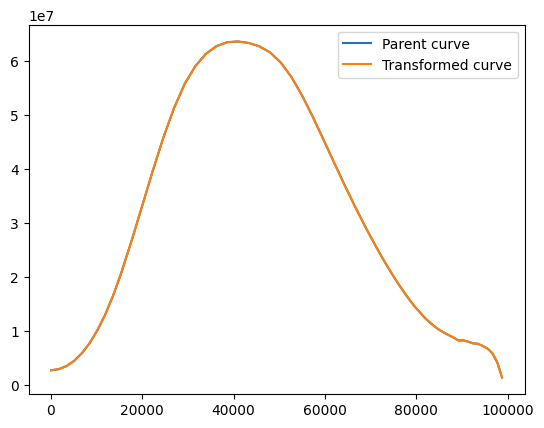

In [8]:
plt.plot(coord_x, areas, label="Parent curve")
plt.plot(lack_x, areas, label="Transformed curve")
plt.legend()
plt.show()

In [11]:
cp = 0.544
desired_cp = 0.532
sub_faces = occhm.get_sections(shape_sur)
delta_cp = desired_cp-cp
lack = occhm.lackenby(shape_sur, delta_cp, 0)
p = occhm.parallel_body_norm(shape_sur)

In [13]:
lack = occhm.lackenby(shape_sur, delta_cp, 0)

In [14]:
lack

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -0.010310836745000296,
 -0.009378857082797332,
 -0.008490753157240337,
 -0.007646524968329337,
 -0.0068461725160642965,
 -0.006089695800445225,
 -0.005377094821472133,
 -0.0047083695791450405,
 -0.004083520073463902,
 -0.0035025463044287574,
 -0.0029654482720395774,
 -0.0024722259762963847,
 -0.002022879417199162,
 -0.0016174085947479274,
 -0.0016174085947479274,
 -0.0014487480455857547,
 -0.0012890281247103833,
 -0.0011382488321217959,
 -0.0009964101678199765,
 -0.000863512131804935,
 -0.000739554724076672,
 -0.0006245379446352002,
 -0.0005184617934804987,
 -0.0004213262706125816,
 -0.00033313137603144087,
 -0.00025387710973708575,
 -0.00018356347172950843,
 -0.00012219046200870692,
 -6.975808057468866e-05,
 -2.6266327427443136e-05,
 8.284797433015146e-06,
 3.3895294006697426e-05,
 5.056516229359954e-05,
 5.8294402293723055e-05,
 5.708301400706587e-05,
 4.69309974336285e-05,
 2.783835257341161e-05,
 -

In [ ]:
new_faces = []
for face, lack_dx in zip(sub_faces, lack):
    if lack_dx != 0:
        obj = face
        dx = lack_dx
        dy = 0
        dz = 0
        # Get the origin point of the object
        origin = obj.Location().Transformation().TranslationPart()
        # Compute the displacement vector
        disp = gp_Vec(dx, dy, dz)
        gp_Ax3(gp_Pnt(), gp_Dir(disp))
        trsf = gp_Trsf()
        trsf.SetTranslation(disp)
        transformer = BRepBuilderAPI_Transform(trsf)
        # Apply the transformation to the surface
        transformer.Perform(face)
        # Get the mirrored surface
        new_faces.append(transformer.Shape())
new_sub = sub_faces[0:len(sub_faces) - len(new_faces)] + new_faces

In [4]:
display, start_display, add_menu, add_function_to_menu = init_display()
display.DisplayShape(shape_sur, update=True, color='black', transparency=False)
for w in sub_faces:
 display.DisplayShape(w, update=True, color=Quantity_Color(0.549,0.573,0.675,Quantity_TOC_RGB))
for l in lack:
 display.DisplayShape(l, update=True, color='blue1')
start_display()

INFO:OCC.Display.backend:The qt-pyside2 backend is already loaded...``load_backend`` can only be called once per session
qt-pyside2 backend - Qt version 5.15.4


In [ ]:
water_plane = Geom_Plane(gp_Pnt(0, 0, water_draft), gp_Dir(0, 0, 1))
water_plane_section = BRepAlgoAPI_Section(shape_sur, water_plane, True).Shape()
water_plane_explorer = TopExp_Explorer(water_plane_section, TopAbs_EDGE)
wire = BRepBuilderAPI_MakeWire()
while water_plane_explorer.More():
    wire.Add(water_plane_explorer.Current())
    if not wire.IsDone():
        edge_explorer = TopExp_Explorer(wire.Edge(), TopAbs_VERTEX)
        while edge_explorer.More():
            last_vert = edge_explorer.Current()
            edge_explorer.Next()
        vertex_explorer = TopExp_Explorer(water_plane_explorer.Current(), TopAbs_VERTEX)
        new_edge = BRepBuilderAPI_MakeEdge(last_vert, vertex_explorer.Current())
        wire.Add(new_edge.Edge())
        wire.Add(water_plane_explorer.Current())
    water_plane_explorer.Next()
water_plane_curve = wire.Wire()
bbox_lwl = Bnd_Box()
bbox_lwl.SetGap(1e-8)
brepbndlib_Add(water_plane_curve, bbox_lwl, False)
xmin, ymin, zmin, xmax, ymax, zmax = bbox_lwl.Get()

In [ ]:
water_plane = Geom_Plane(gp_Pnt(0, 0, water_draft), gp_Dir(0, 0, 1))
water_plane_section = (shape_sur, water_plane, True).Shape()
water_plane_explorer = TopExp_Explorer(water_plane_section, TopAbs_EDGE)
wire = BRepBuilderAPI_MakeWire()
while water_plane_explorer.More():
    wire.Add(water_plane_explorer.Current())
    if not wire.IsDone():
        edge_explorer = TopExp_Explorer(wire.Edge(), TopAbs_VERTEX)
        while edge_explorer.More():
            last_vert = edge_explorer.Current()
            edge_explorer.Next()
        vertex_explorer = TopExp_Explorer(water_plane_explorer.Current(), TopAbs_VERTEX)
        new_edge = BRepBuilderAPI_MakeEdge(last_vert, vertex_explorer.Current())
        wire.Add(new_edge.Edge())
        wire.Add(water_plane_explorer.Current())
    water_plane_explorer.Next()
water_plane_curve = wire
wire_exp = TopExp_Explorer(wire.Wire(), TopAbs_VERTEX)
vert_list = []
while wire_exp.More():
    vert_list.append(wire_exp.Current())
    wire_exp.Next()
xmin_wl = BRep_Tool_Pnt(vert_list[-1]).X()
xmax_wl = BRep_Tool_Pnt(vert_list[0]).X()
y_aft_wl = BRep_Tool_Pnt(vert_list[-1]).Y()
closing_edge = BRepBuilderAPI_MakeEdge(BRep_Tool_Pnt(vert_list[0]), gp_Pnt(xmin_wl, 0, water_draft))
closing_edge2 = BRepBuilderAPI_MakeEdge(gp_Pnt(xmin_wl, 0, water_draft), gp_Pnt(xmin_wl, y_aft_wl, water_draft))
water_plane_curve.Add(closing_edge.Edge())
water_plane_curve.Add(closing_edge2.Edge())
water_plane_face = BRepBuilderAPI_MakeFace(water_plane_curve.Wire())
props_orig = GProp_GProps(gp_Pnt(0, 0, 0))
x_axis = gp_Ax1(gp_Pnt(0, 0, 0), gp_Dir(1, 0, 0))
brepgprop_SurfaceProperties(water_plane_face.Face(), props_orig)
props_orig.MomentOfInertia(x_axis)
props_orig.CentreOfMass().X()

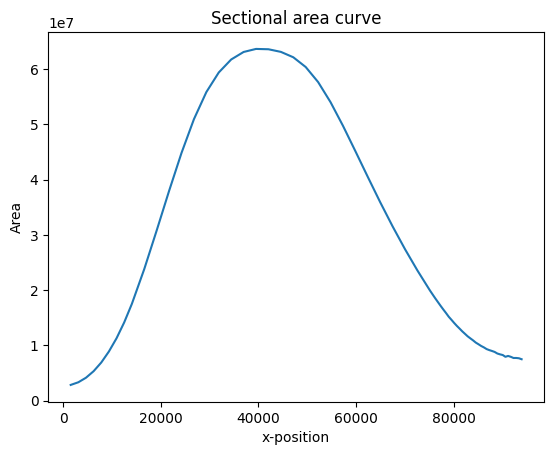

In [10]:
import occhullmanipulation as hm
coords_x = hm.coord_x(shape_sur)
areas = hm.station_areas(shape_sur)
plt.plot(coords_x, areas)
plt.title('Sectional area curve')
plt.xlabel('x-position')
plt.ylabel('Area')
plt.show()

In [11]:
coords_x


[1564.7621666666673,
 3129.5543333333326,
 4694.346499999998,
 6259.138666666672,
 7823.930833333338,
 9388.722999999998,
 10953.515166666672,
 12518.307333333336,
 14083.099500000008,
 14083.099500000008,
 16625.88135416667,
 19168.66320833333,
 21711.44506249999,
 24254.22691666665,
 26797.00877083334,
 29339.790624999994,
 31882.572479166683,
 34425.354333333315,
 36968.1361875,
 39510.91804166667,
 42053.699895833306,
 44596.48175000002,
 47139.26360416665,
 49682.04545833338,
 52224.82731250001,
 54767.609166666654,
 57310.391020833275,
 59853.17287500003,
 62395.954729166595,
 64938.73658333336,
 67481.5184375,
 70024.30029166664,
 72567.08214583334,
 75109.864,
 75109.864,
 75662.14241176474,
 76214.42082352948,
 76766.69923529415,
 77318.97764705885,
 77871.25605882356,
 78423.53447058822,
 78975.81288235294,
 79528.09129411765,
 80080.36970588243,
 80632.64811764701,
 81184.92652941178,
 81737.20494117645,
 82289.4833529412,
 82841.76176470591,
 83394.04017647059,
 83946.31858

In [164]:
len(x[21:])

41

In [160]:
import os
import time
count = 0
arquivo = 'C:\\PycharmProjects\\MasterThesis\\d3v-gsd-occ\\examples\\test.txt'
while not os.path.isfile(arquivo) and count < 10:
    print("Output file being created.")
    time.sleep(1)
    count += 1
else:
    if count == 10:
        print('Time out!')
t1 = time.time()
while os.path.getmtime(arquivo) < t1:
    print(os.path.getmtime(arquivo), t1)
    time.sleep(2)

1677038778.3668602 1677038789.7839475
1677038778.3668602 1677038789.7839475
1677038778.3668602 1677038789.7839475
1677038778.3668602 1677038789.7839475
1677038778.3668602 1677038789.7839475
1677038778.3668602 1677038789.7839475
1677038778.3668602 1677038789.7839475


KeyboardInterrupt: 

In [156]:
if os.path.getmtime(arquivo) < t1:
    print(os.path.getmtime(arquivo), t1)
print(os.path.getmtime(arquivo), t1)

1677038561.2983725 1677038545.5182474


In [ ]:
props_orig = GProp_GProps(gp_Pnt(0,0,0))

coord_x = []
areas = []
stations_zb = []
stations_bwl = []
mom_x = []
stations_bwl_2=[]
x_axis = gp_Ax1(gp_Pnt(0,0,0), gp_Dir(1,0,0))
i_xx = []
for face in sub_faces:
    brepgprop_SurfaceProperties(face, props_orig)
    coord_x.append(props_orig.CentreOfMass().X())
    areas.append(2*props_orig.Mass())
    stations_zb.append(props_orig.CentreOfMass().Z())
    mom_x.append(props_orig.StaticMoments())
    i_xx.append(2*props_orig.MomentOfInertia(x_axis))

In [ ]:
bwl_list = []
for face in sub_faces:
    water_plane_section = BRepAlgoAPI_Section(face, water_plane, True).Shape()
    vert_expl = TopExp_Explorer(water_plane_section, TopAbs_VERTEX)
    vert_list = []
    while vert_expl.More():
        vert_list.append(BRep_Tool_Pnt(vert_expl.Current()).Y())
        vert_expl.Next()
    if vert_list:
        bwl = max(vert_list)
        bwl_list.append(2*bwl)
    else:
        pass

for i in range(len(coord_x) - len(bwl_list)):
    bwl_list.append(0)
print(bwl_list)

In [ ]:
from OCC.Core.gp import gp_Vec, gp_Trsf, gp_Ax3
from OCC.Core.TopoDS import TopoDS_Shape
from OCC.Core.BRepBuilderAPI import BRepBuilderAPI_Transform
new_faces = []
for face, lack_dx  in zip(sub_faces, lack):
    if lack_dx != 0:
        obj = face
        dx = lack_dx
        dy = 0
        dz = 0
        # Get the origin point of the object
        origin = obj.Location().Transformation().TranslationPart()

        # Compute the displacement vector
        disp = gp_Vec(dx, dy, dz)
        gp_Ax3(gp_Pnt(),gp_Dir(disp))

        trsf = gp_Trsf()
        trsf.SetTranslation(disp)

        transformer = BRepBuilderAPI_Transform(trsf)
        # Apply the transformation to the surface
        transformer.Perform(face)
        # Get the mirrored surface
        new_faces.append(transformer.Shape())


In [ ]:
print(len(new_faces))
len(sub_faces)

new_sub = sub_faces[0:len(sub_faces)-len(new_faces)] + new_faces
len(new_sub)

In [ ]:
if T:
    display, start_display, add_menu, add_function_to_menu = init_display()
    display.DisplayShape(shape_sur, update=True, color='black')
    # for n_face in new_faces:
    #     display.DisplayShape(n_face, update=True, color='red')
    # for face in sub_faces:
    #     display.DisplayShape(face, update=True, color='blue1')
    for face in new_sub:
        display.DisplayShape(face, update=True, color='yellow')
    start_display()

In [ ]:
lack_faces_curve = []
for x in [pos + lack_pos for pos, lack_pos in zip(occhm.coord_x(shape_sur), lack)]:
    edge_pl = BRepBuilderAPI_MakeEdge(gp_Pnt(x, y[0], z[0]), gp_Pnt(x, y[1], z[0]))
    edge_pl2 = BRepBuilderAPI_MakeEdge(gp_Pnt(x, y[1], z[0]), gp_Pnt(x, y[1], z[1]))
    edge_pl3 = BRepBuilderAPI_MakeEdge(gp_Pnt(x, y[1], z[1]), gp_Pnt(x, y[0], z[1]))
    edge_pl4 = BRepBuilderAPI_MakeEdge(gp_Pnt(x, y[0], z[1]), gp_Pnt(x, y[0], z[0]))
    wire_pl = BRepBuilderAPI_MakeWire()
    wire_pl.Add(edge_pl.Edge())
    wire_pl.Add(edge_pl2.Edge())
    wire_pl.Add(edge_pl3.Edge())
    wire_pl.Add(edge_pl4.Edge())
    subm_stations_planes = BRepBuilderAPI_MakeFace(wire_pl.Wire()).Face()
    curve = BRepAlgoAPI_Section(shape_sur, subm_stations_planes, True)
    explorer = TopExp_Explorer(curve.Shape(), TopAbs_EDGE)
    wire = BRepBuilderAPI_MakeWire()
    vertx = []
    while explorer.More():
        wire.Add(explorer.Current())
        if not wire.IsDone():
            edge_explorer = TopExp_Explorer(wire.Edge(), TopAbs_VERTEX)
            while edge_explorer.More():
                last_vert = edge_explorer.Current()
                edge_explorer.Next()
            vertex_explorer = TopExp_Explorer(explorer.Current(), TopAbs_VERTEX)
            new_edge = BRepBuilderAPI_MakeEdge(last_vert, vertex_explorer.Current())
            wire.Add(new_edge.Edge())
            wire.Add(explorer.Current())
        explorer.Next()
    close_vert_explorer = TopExp_Explorer(wire.Wire(), TopAbs_VERTEX)
    while close_vert_explorer.More():
        vertx.append(close_vert_explorer.Current())
        close_vert_explorer.Next()
    vertx.sort(key=lambda coord: BRep_Tool_Pnt(coord).Z())
    initial_vert = vertx[0]
    final_vert = vertx[-1]
    closing_edge = BRepBuilderAPI_MakeEdge(BRep_Tool_Pnt(final_vert),
                                           gp_Pnt(BRep_Tool_Pnt(final_vert).X(),0,BRep_Tool_Pnt(final_vert).Z()))
    closing_edge2 = BRepBuilderAPI_MakeEdge(gp_Pnt(BRep_Tool_Pnt(final_vert).X(),0,BRep_Tool_Pnt(final_vert).Z()),
                                            gp_Pnt(BRep_Tool_Pnt(final_vert).X(),0,BRep_Tool_Pnt(initial_vert).Z()))
    if closing_edge.IsDone() and closing_edge2.IsDone():
        wire.Add(closing_edge.Edge())
        wire.Add(closing_edge2.Edge())
    else:
        continue
    if wire.IsDone():
        lack_faces_curve += [wire.Wire()]
    else:
        pass
lack_faces = []
for station in subm_section_curves:
    lack_faces.append(BRepBuilderAPI_MakeFace(station).Face())
if T:
    display, start_display, add_menu, add_function_to_menu = init_display()
    display.DisplayShape(shape_sur, update=True, color='black')
    for n_face in lack_faces:
        display.DisplayShape(n_face, update=True, color='red')
    for face in sub_faces:
        display.DisplayShape(face, update=True, color='blue1')
    start_display()

In [ ]:
from OCC.Core.gp import gp_Vec, gp_Trsf, gp_Ax3
from OCC.Core.TopoDS import TopoDS_Shape
from OCC.Core.BRepBuilderAPI import BRepBuilderAPI_Transform
obj = shape_sur
dy = 15000
dx = 0
dz = 0
# Get the origin point of the object
origin = obj.Location().Transformation().TranslationPart()

# Compute the displacement vector
disp = gp_Vec(dx, dy, dz)
gp_Ax3(gp_Pnt(),gp_Dir(disp))
# Compute the transformation matrix
# trsf = BRepBuilderAPI_Transform(gp_Trsf())
trsf = gp_Trsf()
trsf.SetTranslation(disp)

transformer = BRepBuilderAPI_Transform(trsf)
# Apply the transformation to the surface
transformer.Perform(shape_sur)
# Get the mirrored surface
moved_surface = transformer.Shape()


if T:
    display, start_display, add_menu, add_function_to_menu = init_display()
    display.DisplayShape(shape_sur, update=True, color='black')
    display.DisplayShape(moved_surface, update=True, color='red')

    start_display()


In [ ]:
vol = sci.integrate.simps(areas, coord_x)
tot_mom = [area * x for area, x in zip(areas, coord_x)]
vcb = [area * z for area, z in zip(areas, stations_zb)]
vcb = sci.integrate.simps(vcb, coord_x)/vol

sum(i_xx)/vol + (vcb - zmin)

In [ ]:
x = [-3721.794479999998, -3470.4122871409927, -2719.2129349343063, -1477.003548956451, 241.65210150485117, 2416.6043503297924, 5022.353870978707, 8028.350632781496, 11399.352072115063, 15095.836279239238, 19074.46535655322, 23288.593515820776, 27688.81395738861, 32223.538119739245, 36839.60050820692, 41482.882011793066, 46098.94440026075, 50633.66856261143, 55033.88900417925, 59248.017163446806, 63226.64624076077, 66923.13044788492, 70294.13188721846, 73300.12864902135, 75905.8781696702, 78080.83041849516, 79799.48606895647, 81041.69545493423, 81792.89480714098, 82044.277]
y = [14622.531817976298, 14623.824829207611, 14642.378485341342, 14717.766193073958, 14893.11588445285, 15169.389829192558, 15472.560417676834, 15715.795589576152, 15873.239807514987, 15957.101485518306, 15990.97942606027, 15999.393805370593, 16000.007924576288, 16000.007254651084, 15999.992580733644, 15956.939213074907, 15568.07258193969, 14504.252413201384, 12881.977337096032, 11020.805627511945, 9191.865530940751, 7490.622077895954, 5949.776532636624, 4578.442992822562, 3389.7217374933803, 2753.055182848947, 2768.021403251978, 2798.4954704618544, 2820.5256160971826, 2828.0604913834445]

plt.plot(x, y)